In [214]:
using ISOKANN
using SqraCore
using LinearAlgebra
using Plots
using StatsBase

In [215]:
rownormalize(x; p=2) = (x ./ norm.(eachrow(x), p))

colnormalize(x; p=2) = (x ./ norm.(eachcol(x), p)')

signfirstrow(x) = x ./ sign.(x[1, :])'

normcols(x) = signfirstrow(colnormalize(x))

normcols (generic function with 1 method)

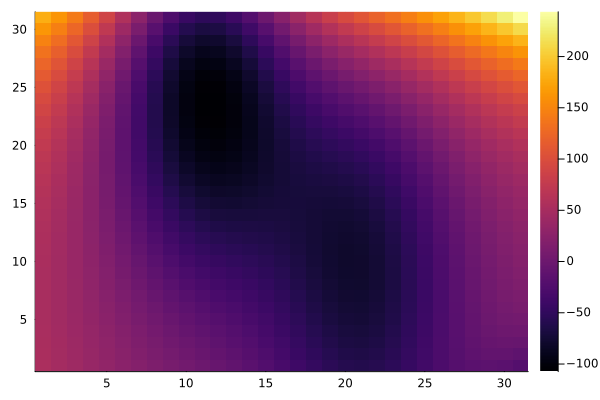

eigenvectors
1.0000000000000033 + 0.0im
0.9430773127210207 + 0.0im
0.8700923625019256 + 0.0im
0.8237203498601761 + 0.0im
0.7672824630548899 + 0.0im
0.7323826707123475 + 0.0im
0.6798770120356847 + 0.0im
0.6456165867854878 + 0.0im
0.6011951505527932 + 0.0im
0.5906826571394413 + 0.0im


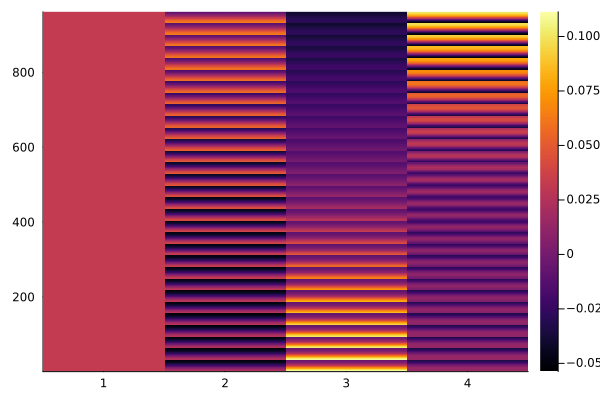

In [216]:
function generate_K_ev(M=4)

    xs = -1.5:0.05:1
    ys = -0.5:0.05:1
    pot = [ISOKANN.mueller_brown(x, y) for x in ys, y in ys]

    Plots.heatmap(pot) |> display

    Q = sqra_grid(pot, beta=0.02)
    K = exp(collect(Q) .* 0.1)
    vals = eigen(K, sortby=x -> real(-x)).values[1:10]
    println("eigenvectors")
    println.(vals)

    eigenvecs = eigen(K, sortby=x -> real(-x)).vectors

    ev = eigenvecs[:, 1:M] |> real |> signfirstrow
    heatmap(ev) |> display
    K, ev
end

K, ev = generate_K_ev();

In [229]:
function generate_LR(;eta = 0.001, K=K, n=10)
    L = randn(size(ev)) |> normcols

    for i in 1:n
        L = K * L
        L = normcols(L + randn(size(L)) * eta)
        q, r = qr(L)
        L = q[:, 1:4]
    end
    R = K*L
    
    
    #@show norm(L), norm(R)
    L, R
end
L, R = generate_LR()

([-0.037828246970848634 -0.01584956636244213 -0.06877926444972697 -0.09965201968358438; -0.0403519311706073 -0.017950813255126263 -0.06736355715045696 -0.10007917044242423; … ; -0.018197051003590266 0.09493934562070269 -0.04336255519214905 -0.04759507915867604; -0.02013207720739549 0.09900616789147107 -0.045211149607563644 -0.049419417582831075], [-0.03924601988147345 -0.023770426230076077 -0.05583000505517789 -0.07909081687952375; -0.039341047935067666 -0.024301396700960366 -0.05440185375804624 -0.07761711137575651; … ; -0.02213669776788 0.07924522828354436 -0.029992246695627413 -0.03613014689858297; -0.021836984520289007 0.08019453423209497 -0.030128471104376733 -0.03710802118402038])

In [230]:
function pi1(L, R)
    x = L'
    y = R'

    @assert size(x, 1) < size(x, 2)
    kinv = x * pinv(y)
    e = eigen(kinv)
    #@show 1 ./ e.values
    Q = e.vectors
    target_pi1 = (inv(Q) * y)'
    target_pi1 = normcols(target_pi1)
end

target_pi1 = pi1(L, R);

In [231]:
function pi2(L, R)
    x = L'
    y = R'

    @assert size(x, 1) < size(x, 2)
    k = y * pinv(x)
    e = eigen(k)
    #@show e.values[end:-1:1]
    Q = e.vectors[:, end:-1:1] |> real

    target_pi2 = (Q * y)'
    target_pi2 = normcols(target_pi2);
end

target_pi2 = pi2(L, R);

In [232]:
# these are all the same
pinv(L) * R
L \ R
R' / L'
R' * pinv(L');

In [233]:
function lr1(L, R)
    @assert size(L, 1) > 100
    M = size(L, 2)

    # compute qr basis of LR space -- q is basis, r are components
    LR = hcat(R, L)
    q,r = qr(LR)
    @assert q[:, 1:8] * r ≈ LR

    D = size(L, 2)
    # representation of image and preimage in that basis
    qR = r[:, 1:D]
    qL = r[:, D+1:end]

    # estimate map in this space
    A = qL * pinv(qR)
    e = eigen(A)
    #@show e.values
    Q = e.vectors

    # project eigenvectors back to original space
    t = q * Q
    return normcols(t[:, M+1:end])
end

target_lr1 = lr1(L, R);

In [234]:
function lr2(L, R)
    @assert size(L, 1) > 100
    M = size(L, 2)

    # compute qr basis of LR space -- q is basis, r are components
    LR = hcat(R, L)
    q, r = qr(LR)
    @assert q[:, 1:8] * r ≈ LR

    D = size(L, 2)
    # representation of image and preimage in that basis
    qR = r[:, 1:D]
    qL = r[:, D+1:end]

    # estimate map in this space
    A = qR * pinv(qL)
    e = eigen(A)
    #@show e.values
    Q = e.vectors

    # project eigenvectors back to original space
    t = q * Q[:, end:-1:M+1]
    return normcols(t)
end

target_lr2 = lr2(L, R);

In [235]:
mapreduce(hcat, [target_lr1, target_lr2, target_pi1, target_pi2, R]) do x
    x = normcols(x)
    norm.(eachcol(x .- ev))
end


4×5 Matrix{Float64}:
 0.079089   0.0609266  0.0609174  0.0639452  0.200637
 0.0897877  0.0718997  0.0721614  1.97498    1.2402
 0.346658   0.313972   0.317015   0.30626    1.28307
 0.622265   0.595733   0.59519    0.627131   1.14264

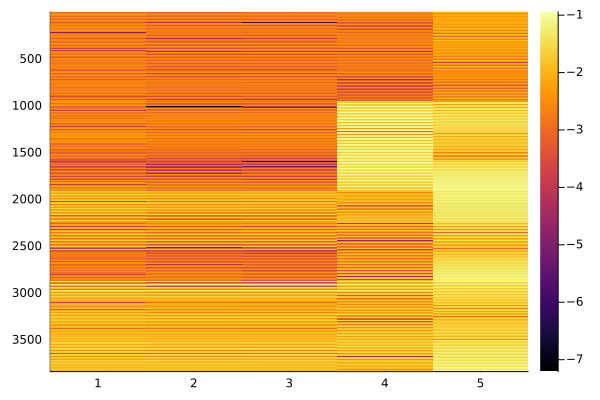

In [236]:
heatmap(([vec(target_lr1) vec(target_lr2) vec(target_pi1) vec(target_pi2) vec(normcols(R))] .- vec(ev)) .|> abs .|> log10, yflip=true)

In [238]:
function benchmark(;eta = 0.001, n=5, m=1000)
    es = mapreduce(vcat, 1:m) do x
        L, R = generate_LR(;eta, n)
        target_lr1 = lr1(L,R)
        target_lr2 = lr2(L,R)
        target_pi1 = pi1(L,R)
        target_pi2 = pi2(L,R)

        e = mapreduce(hcat, [target_lr1, target_lr2, target_pi1, target_pi2, R]) do x
            x = normcols(x)
            norm.(eachcol(x .- ev))
        end
        sum(e, dims=1)
    end
end
es = benchmark()
[mean(es, dims=1)
median(es, dims=1)
std(es, dims=1)]



3×5 Matrix{Float64}:
 3.97574  3.81563  3.75675  4.85238   4.97523
 3.87123  3.7655   3.6694   4.90549   5.03954
 1.11434  1.1207   1.11847  0.912206  0.825941